In [1]:
import torch
from torch import nn
from tqdm import tqdm

from lib.utils import *
from lib.models import *

window_size = 101
device = 'cuda'
f1i = []
recalli = []
precisioni = []
model_name = 'res'
i = 0
criterion = nn.BCEWithLogitsLoss()
model = ResNet()
model.load_state_dict(torch.load(f=f'../projects/{model_name}_cv_{i}/best_model.pt',map_location='cuda:0'))

<All keys matched successfully>

In [2]:
_,_,test_idx = load_data_convolution_cv(foldi=i)

In [3]:
test_idx

[12, 39, 33, 43, 53, 50, 57, 5, 7, 60, 65, 68]

In [5]:
X,y = load_and_window_nursing_list_for_convolution([test_idx[0]])

In [6]:
logits = model(X)

/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


In [7]:
probits = torch.sigmoid(logits).detach().cpu()

In [8]:
probits

tensor([[6.0326e-17],
        [8.5066e-17],
        [1.0628e-16],
        ...,
        [3.5377e-22],
        [9.1046e-21],
        [2.2285e-18]])

In [9]:
Xi,yi = load_nursing_by_index(12)

Text(142.97222222222223, 0.5, 'Acceleration')

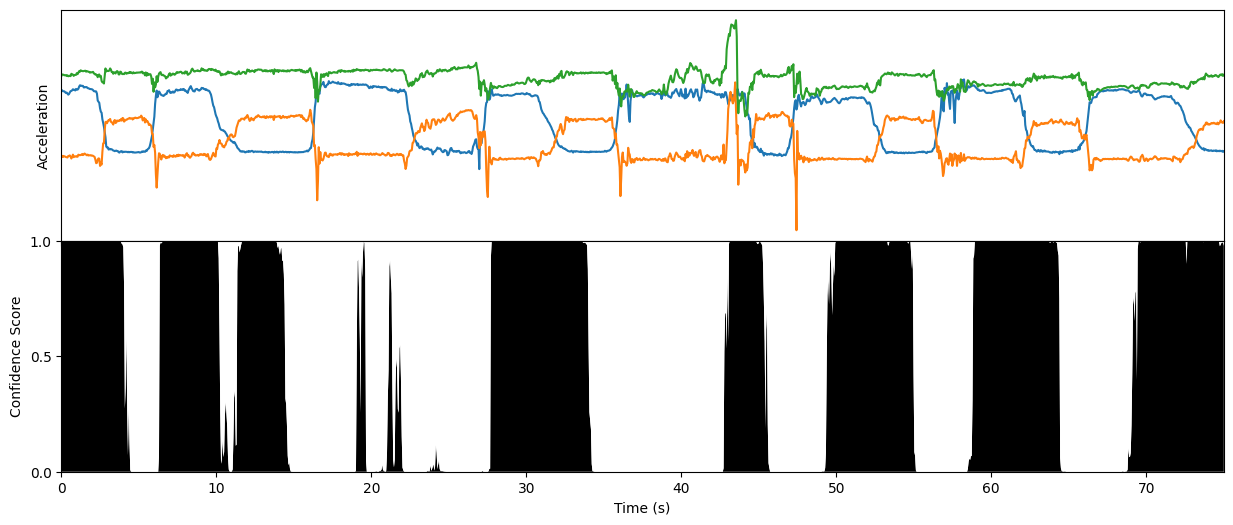

In [10]:
fig,axes = plt.subplots(2,1,figsize=(15,6))
start = 26000
stop = 27500
axes[1].stackplot(np.linspace(0,(stop-start)/20,stop-start),probits[start:stop].squeeze(),1-(probits[start:stop].squeeze()),colors=['black','white'])
axes[0].plot(np.linspace(0,(stop-start)/20,stop-start),Xi[start:stop])
plt.savefig('out.jpg',bbox_inches='tight')
axes[0].margins(x=0)
axes[1].margins(x=0)
# axes[0].margins(y=0)
axes[1].margins(y=0)
plt.subplots_adjust(wspace=0, hspace=0)
axes[0].set_xticklabels([])
axes[0].set_yticks([])
axes[1].set_yticks([0,.5,1])
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Confidence Score')
axes[0].set_ylabel('Acceleration')

In [ ]:

# X,y = load_and_window_nursing_list(test_idx)
loss,y_true,y_pred = test_evaluation(DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True),model,criterion,plot=True,filename=f'{model_name}_cv_{i}')

In [ ]:


for i in range(5):
    model = FCN()
    model.load_state_dict(torch.load(f=f'../projects/{model_name}_cv_{i}/best_model.pt',map_location='cuda:0'))
    # trainloader,devloader,test_idx = load_data_cv(foldi=i)
    trainloader,devloader,test_idx = load_data_convolution_cv(foldi=i)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    test_evaluation(trainloader,model,criterion,dir=f'.',filename=f'{model_name}_cv_{i}_train.jpg',device=device)
    test_evaluation(devloader,model,criterion,dir=f'.',filename=f'{model_name}_cv_{i}_dev.jpg',device=device)
    X,y = load_and_window_nursing_list_for_convolution(test_idx)
    # X,y = load_and_window_nursing_list(test_idx)
    loss,y_true,y_pred = test_evaluation(DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True),model,criterion,plot=True,filename=f'{model_name}_cv_{i}')
    f1i.append(f1_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
    recalli.append(recall_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
    precisioni.append(precision_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
    f1i = []
    recalli = []
    precisioni = []
    for idx in test_idx:
        X,y = load_and_window_nursing_list_for_convolution([idx])
        loss,y_true,y_pred = test_evaluation(DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True),model,criterion,plot=True)
        f1i.append(f1_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
        recalli.append(recall_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
        precisioni.append(precision_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))

In [ ]:
plt.figure(figsize=(7.2,4.45),dpi=200)
sns.kdeplot(recalli,bw_adjust=.4,color='red',label='recall')
sns.rugplot(recalli,color='red',linewidth=1.618)
print(torch.tensor(recalli).mean()) #.4958
print(torch.tensor(recalli).std()) #.0063
sns.kdeplot(f1i,bw_adjust=.4,color='green',label='f1')
sns.rugplot(f1i,color='green',linewidth=1.618)
print(torch.tensor(f1i).mean()) #.4958
print(torch.tensor(f1i).std()) #.0063
sns.kdeplot(precisioni,bw_adjust=.4,color='blue',label='precision')
sns.rugplot(precisioni,color='blue',linewidth=1.618)
print(torch.tensor(precisioni).mean()) #.4958
print(torch.tensor(precisioni).std()) #.0063

In [ ]:
df = pd.DataFrame([f1i,precisioni,recalli],index=['f1','precision','recall'])
df_melted = df.reset_index().melt(id_vars=['index'])
sns.barplot(data=df_melted,x='variable',y='value',hue='index')
plt.xlabel('fold index')
plt.ylabel('score')
df_melted

In [ ]:
from sklearn.metrics import f1_score,recall_score,precision_score


In [ ]:
idx = test_idx[0]
import plotly.express as px
holdoutloader = DataLoader(TensorDataset(*load_and_window_nursing_list_for_convolution([idx])),batch_size=32,shuffle=False)
loss,y_true,y_pred = test_evaluation(holdoutloader,model,criterion)
X,y = load_nursing_by_index(idx)
df = pd.DataFrame(X.numpy())
df['y_pred'] = torch.cat([torch.zeros(window_size//2),y_pred.flatten().round(),torch.zeros(window_size//2)])*10
df['y_true'] = y*10
fig = px.line(df)
fig.show(renderer='browser')